## Imports

In [5]:
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt

# Make sure you have an enviromental path defined
picaso_refdata_str = os.environ.get('picaso_refdata')

# You can also defined the necessary paths this way
#os.environ['picaso_refdata'] = 'your_path' #THIS MUST GO BEFORE YOUR IMPORT STATEMENT
#os.environ['PYSYN_CDBS'] = 'your_path' #this is for the stellar data discussed below.

# Set the relative file paths
base_path = Path(picaso_refdata_str)
pysyn_cdbs_path = str(base_path / 'grp' / 'redcat' / 'trds')
ck_db_path = str(base_path / 'sonora_2020_feh+000_co_100.data.196/')
sonora_profile_db_path = str(base_path / 'sonora_profile/')

import numpy as np
from picaso import justdoit as jdi

## Set up the PICASO connection for two test cases (mono and correlated-k)

In [6]:
opacity_mono = jdi.opannection()
opacity_ck = jdi.opannection(ck_db=ck_db_path,
                             method='preweighted')

gases_fly = ['H2O', 'CH4', 'H2', 'CO', 'NH3', 'TiO', 'VO', 'Na', 'K','CO2', 'H', 'He']
opacity_resort =  jdi.opannection(method='resortrebin',
                                  preload_gases=gases_fly)

calc = {'mono':  opacity_mono,
        'ck':    opacity_ck,
        'resort': opacity_resort}

cases = {}
df = {}

# Define some parameters for the simulation
stellar_temp   = 6000
stellar_met    = 0.0
stellar_logg   = 4.0
orbital_sep    = 0.05
stellar_radius = 1
rsol = 6.957e8
au   = 1.496e11
blackbody_temp = 1000

for key in ['mono','ck', 'resort']:
    cases[key] = jdi.inputs()

    cases[key].approx(get_lvl_flux=True)
 
    # Set common parameters: phase angle and gravity.
    cases[key].phase_angle(0)
    cases[key].gravity(radius=1, radius_unit=jdi.u.Unit('R_jup'),mass=1, mass_unit=jdi.u.Unit('M_jup'))
    
    # Set stellar parameters (same for both)
    cases[key].star(calc[key],
                    stellar_temp,
                    stellar_met,  
                    stellar_logg, 
                    radius=stellar_radius,
                    radius_unit=jdi.u.Unit('R_sun'),
                    semi_major=orbital_sep,
                    semi_major_unit=jdi.u.Unit('au'))
    Teff = 1000 
    cases[key].sonora(sonora_profile_db_path, Teff, chem='grid')
    atm = cases[key].inputs['atmosphere']['profile']

    # Hardcode a blackbody for testing
    atm.temperature = blackbody_temp
    cases[key].atmosphere(df=atm)
    df[key] = cases[key].spectrum(calc[key], full_output=True, calculation='thermal+reflected')   

/Users/imalsky/Documents/picaso/picaso/optics.py:1410: UserWarning: Warning: npy files for DEQ will be deprecated in a future PICASO udpate. Please download the hdf5 files, explanation here https://natashabatalha.github.io/picaso/notebooks/climate/12c_BrownDwarf_DEQ.html
  warnings.warn(' '.join(np.unique(msg)), UserWarning)


## Grab the thermal fluxes, reflected fluxes, and pressure levels from the ful output

In [7]:
# Get the data out of the picaso run
thermal_plus = df['ck']['full_output']['level']['thermal_fluxes']['flux_plus']
thermal_minus = df['ck']['full_output']['level']['thermal_fluxes']['flux_minus']
reflected_plus = df['ck']['full_output']['level']['reflected_fluxes']['flux_plus']
reflected_minus = df['ck']['full_output']['level']['reflected_fluxes']['flux_minus']
pressures = df['ck']['full_output']['level']['pressure']

# Sum the binned fluxes to get the bolometric values
integrated_thermal_plus = np.sum(thermal_plus, axis=1)
integrated_thermal_minus = np.sum(thermal_minus, axis=1)
integrated_reflected_plus = np.sum(reflected_plus, axis=1)
integrated_reflected_minus = np.sum(reflected_minus, axis=1)

## Plot the thermal and reflected layer fluxes

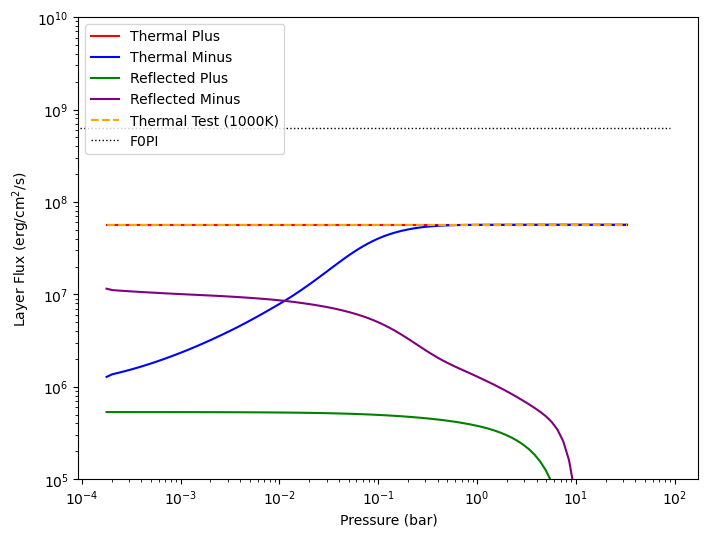

In [9]:
# Compute incident flux
F0PI = (5.67e-5 * stellar_temp ** 4) * (((stellar_radius * rsol) / (orbital_sep * au)) ** 2)

plt.figure(figsize=(8, 6))

# Plot thermal and reflected fluxes, both up and down
plt.plot(pressures, integrated_thermal_plus, label='Thermal Plus', color='red')
plt.plot(pressures, integrated_thermal_minus, label='Thermal Minus', color='blue')
plt.plot(pressures, integrated_reflected_plus, label='Reflected Plus', color='green')
plt.plot(pressures, integrated_reflected_minus, label='Reflected Minus', color='purple')

# Add reference flux lines for thermal and starlight
plt.plot(pressures,
         [5.67e-5 * blackbody_temp ** 4] * len(pressures),
         label='Thermal Test (1000K)',
         color='orange',
         linestyle='dashed')

plt.plot([np.sum(F0PI)] * len(pressures),
         label='F0PI',
         linestyle='dotted',
         linewidth=1,
         color='black')

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e5, 1e10)
plt.ylabel(r'Layer Flux (erg/cm$^2$/s)')
plt.xlabel('Pressure (bar)')
plt.legend(loc='best')
